<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
import copy
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [5]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving iu-2.jpeg to iu-2.jpeg

Upload Style Image


Saving iu-6.jpeg to iu-6.jpeg
Content Path: <_io.BytesIO object at 0x7f2856f4f8e0>
Style Path: <_io.BytesIO object at 0x7f2856f4f990>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**



**DONE:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image



In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()  # Download the pretrained module.
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [8]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
# From the paper, content is conv4_2, and style is conv1_1, conv2_1, conv3_1,
# conv4_1, conv5_1

# Create the vgg network in eval mode
# with our forward method that returns the outputs of the intermediate layers we requested
vgg_content = VGGIntermediate(requested=[vgg_names.index("conv4_2")]).cuda()
vgg_style = VGGIntermediate(requested=[vgg_names.index("conv1_1"),
                                       vgg_names.index("conv2_1"),
                                       vgg_names.index("conv3_1"),
                                       vgg_names.index("conv4_1"),
                                       vgg_names.index("conv5_1")]).cuda()
                                        
# Cache the outputs of the content and style layers for their respective images
content_out = vgg_content(content_image)
style_out = vgg_style(style_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s]


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**


**DONE:**

* Display the style tensor and content tensor transformed back to an image


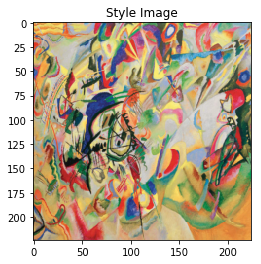

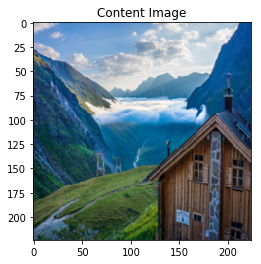

In [9]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

___

### Part 3
Create a classes for the style and content loss

**TODO:**



**DONE:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [0]:
def gram_matrix(x):
  b, f, h, w = x.size()
  matrix = x.view(b*f, h*w)  # reshape
  G = torch.mm(matrix, matrix.t()) # matrix multiply
  return G.div(b * f * h * w)  # normalize
  
# Instantiate a sytle loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
class StyleLoss(nn.Module):
  def __init__(self, picture_features):
    super(StyleLoss, self).__init__()
    self.picture = gram_matrix(picture_features).detach()  # Do not backprop into our matrix!
    
  def forward(self, x):
    G = gram_matrix(x)   # Blur the styling together.
    self.loss = F.mse_loss(G, self.picture)       # TODO: Check with TA's about style loss.
    # print(self.loss.size())
    return self.loss  # Don't change anything network.

# Instantiate a content loss module for each content layer 
# with the content reference image outputs for that layer for comparison
class ContentLoss(nn.Module):
  def __init__(self, picture_features):
    super(ContentLoss, self).__init__()
    self.picture = picture_features.detach()  # Do not backprop into our matrix!
    
  def forward(self, x):
    self.loss = F.mse_loss(x, self.picture)
    return self.loss  # Don't change anything in our network.

  
# TODO: MAYBE INSTANTIATE! 

___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


epoch 0:
Style Loss : 2648.125244 Content Loss: 0.000000
epoch 50:
Style Loss : 45.895000 Content Loss: 66.532921
epoch 100:
Style Loss : 28.517172 Content Loss: 47.955013
epoch 150:
Style Loss : 146.050323 Content Loss: 67.431320
epoch 200:
Style Loss : 33.217880 Content Loss: 54.956379
epoch 250:
Style Loss : 26.231480 Content Loss: 42.487278


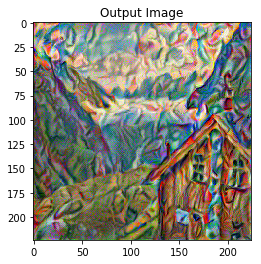

In [44]:
# Start with a copy of the content image.
content_image_copy = copy.deepcopy(content_image)

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors
optimizer = optim.Adam([content_image_copy.requires_grad_()], lr=.1)

# a/b ratio   1/.001  or 1/.0001
# so alpha 1 beta 1000 or alpha 1 beta 10,000
# alpha is content, beta is style.
alpha_wieght = 1
beta_wieght = 10000

vgg_model = VGGIntermediate(requested=[
                                        vgg_names.index("conv4_2"),
                                        vgg_names.index("conv1_1"),
                                        vgg_names.index("conv2_1"),
                                        vgg_names.index("conv3_1"),
                                        vgg_names.index("conv4_1"),
                                        vgg_names.index("conv5_1"),
                                       ]).cuda()
                                 
iterations = 300
for epoch in  range(iterations):
  
  gc.collect()
  content_loss = []
  style_loss = []
  optimizer.zero_grad()
  
  content_image_copy.data.clamp_(0, 1)
  target_features = vgg_model(content_image_copy)
  
  for i in content_out:
    loss = ContentLoss(content_out[i]).forward(target_features[i]) # force the forward method. Compare content to target.
    content_loss.append(loss)

  for i in style_out:
    loss = StyleLoss(style_out[i]).forward(target_features[i])
    style_loss.append(loss)
    
  style_score, content_score = 0, 0

  for xy in content_loss:
    content_score += xy
    
  for xy in style_loss:
    style_score += xy

  content_score *= alpha_wieght
  style_score *= beta_wieght

  loss = (content_score + style_score) * .2
  loss.backward()
  optimizer.step()

  if epoch % 50 == 0:
    print("epoch {}:".format(epoch))
    print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
  
# Keep our stuff in range.
content_image_copy.data.clamp_(0, 1)

# Show the image
plt.figure()
display(content_image_copy, title='Output Image')

### Part 5

**TODO:**



**DONE:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

 Equation 1 calculates the content loss for an image. F is the activations of layer L. Fij is each individual activation in F. P is the original content picture. We subtract P from F and square the result. We add all these up for each item in the matrix i, j. We then divide by 2 to get the MSE error.

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

  Equation 3 calculates the gram matrix. Which is the inner product between the feature map Fi and the feature map Fj where F is the input image. K is how many items each feature map contains and we sum all the inner products together.

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

 Equation 4 calculates the style loss of the layer l. Where Gij is the gram matrix output of the image to be generated. Aij is the gram matrix of the style image. Aij is subtracted from Gij which is squared and a summed over all instances i, j in the matrix. This is then multplied by one divided by 4 times Ml^2 and Nl^2. Where Ml is the dimensions h*w of the matrix and Nl is the feature map length.

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

 This calculates the total style loss by summing up the loss for each layer multiplied by the weights for the layer. Where wieghts is the value 1 divided by active layers. Since we are using 5 layers in our network we would do 1/5.

 